# Sample star catalog generation using genstars

                                                                                                                                            by Naoki Koshimoto on June 29, 2022

`genstars` is developed for simulations of two microlensing surveys, the PRIME survey (Kondo et al. in prep.) and the Roman survey (Johnson et al. in prep.), both toward the inner bulge region (|b| < ~2 deg.).
Similar, but separate tools were used for these two simulations, and this public version combined the two.  
For this reason, there are largely two modes in genstars;
1. PRIME mode (default):  
    - generate a star catalog in V-, I-, J-, H-, and Ks-bands.  
    - Use empirical+isochrone mass-luminosity relation taken from the [Baraffe et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003A%26A...402..701B/abstract) isochrone models for $M \leq 0.08 M_{\odot}$, the [Henry & McCarthy (1993)](https://ui.adsabs.harvard.edu/abs/1993AJ....106..773H/abstract) empirical relation for $0.09 M_{\odot} \leq M \leq 0.48 M_{\odot}$, and the [PARSEC isochrone models](http://stev.oapd.inaf.it/cgi-bin/cmd) for $M \geq 0.55 M_{\odot}$. The gaps between different relations are interpolated linearly.
2. Roman mode (with "ROMAN 1"): 
    - generate a star catalog in J-, H-, Ks-, Z086-, W146-, and F213-bands.  
    - Use isochrone mass-luminosity relation taken from the [Baraffe et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003A%26A...402..701B/abstract) isochrone models for $M \leq 0.08 M_{\odot}$ and the [PARSEC isochrone models](http://stev.oapd.inaf.it/cgi-bin/cmd) for $M \geq 0.09 M_{\odot}$. The gaps between different relations are interpolated linearly. The Baraffe isochrone models are unavailable for the Z086-, W146-, and F213-bands, so W146 is assumed to be ~J-mag while Z086- and F213-mags are assigned 99 mag when $M \leq 0.08 M_{\odot}$.

The two different treatments on the mass-luminosity relations are due to each authors' preferences.  So, although both modes contain J-, H-, and Ks-band magnitudes, they are slightly different between the two modes.


By default, it uses the PRIME mode. By adding "ROMAN 1" to the argument, it uses the Roman mode.

Below, I present very simple examples of genstars runs. Note that I'm kind of a new python user and there's a good chance that I'm doing something strange or uncommon.

In [1]:
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_header (command) :
    ROMAN = 0
    VERBOSITY = 0
    iMag = -1
    args = command.split()
    for i, arg in enumerate(args) :
        if arg == 'ROMAN' : 
            ROMAN = int(args[i+1])
        if arg == 'VERBOSITY' :
            VERBOSITY = int(args[i+1])
        if arg == 'iMag' :
            iMag = int(args[i+1])
    if iMag == -1 :
        if (ROMAN == 1) : 
            iMag = 4
        else : 
            iMag = 3      
    
    if ROMAN == 1 :
        Mags =['J', 'H', 'Ks', 'Z087', 'W146', 'F213']
    else :
        Mags = ['V', 'I', 'J', 'H', 'Ks']
    
    if VERBOSITY == 3 :
        Alams = ['A' + mag for mag in Mags]
    else :
        Alams = ['A' + Mags[iMag]]

    Mags = [mag + '-mag' for mag in Mags]
        
    if VERBOSITY == 3 :
        header = Mags + Alams + 'Mass      Radius   Distance      mu_l      mu_b   l   b cls fREM InitialMass      v_x      v_y      v_z'.split()
    elif VERBOSITY == 2 :
        header = Mags + 'Mass      Radius   Distance      mu_l      mu_b'.split() + Alams + 'l  b cls fREM   InitialMass      v_x      v_y      v_z'.split()
    elif VERBOSITY == 1 :
        header = Mags + 'Mass      Radius   Distance      mu_l      mu_b'.split() + Alams + 'l  b cls fREM'.split()
    else :
        header = None

    return header
    
def run_genstars (command) :
    print("# Conducted command (you can do this directly in your command line too): ")
    print("{}".format(command))
    subprocess.run(command, shell=True, text=True)
    return get_header(command)
    

## A luminous star catalog generation with `Magrange`
The following command output a list of stars with a brightness of 13 < H < 20, within 0.9 < l < 1.1, -0.8 < b < -0.6.

In [3]:
%%time
# Conduct genstars and output the star (13 < H < 20) catalog to tmp.dat
file = 'tmp.dat'
header = run_genstars("./genstars l 0.9 1.1 b -0.8 -0.6 ROMAN 0 fSIMU 0.01 iMag 3 Magrange 13 20 VERBOSITY 1 seed 2 > {}".format(file))

# Conducted command (you can do this directly in your command line too): 
./genstars l 0.9 1.1 b -0.8 -0.6 ROMAN 0 fSIMU 0.01 iMag 3 Magrange 13 20 VERBOSITY 1 seed 2 > tmp.dat
CPU times: user 3.52 ms, sys: 11 ms, total: 14.6 ms
Wall time: 1.34 s


where each parameter in the arguments is :
- `l [double] [double]` (default: 1.875, 2.125)  
  Range of galactic longitude simulated. The first value has to smaller than the second.  
  Currently need to be -9.5 < l < 9.5.  

- `b [double] [double]` (default: -1.625, -1.375)  
  Range of galactic latitude simulated. The first value has to smaller than the second.  
  Currently need to be -10.0 < b < 4.5.

- `ROMAN [int]` (default : 0)  
  If 0, use the PRIME mode. If 1, use the Roman mode. See the top of this notebook about the difference. Note that "ROMAN 0" can be omitted because it's default although I put there to make it explicit.
  
- `fSIMU [double]` (default: 0.01)  
  A fraction to limit the output file size, and fSIMU = 0.01 means it will output the 0.01 times number of stars with the actual model stellar number density.
  
- `iMag [int]` (default: 3 if ROMAN ==0, 4 if ROMAN == 1)  
  Parameter to specify the reference band.  
  If ROMAN = 0, iMag = 0, 1, 2, 3, 4 correspond to V-, I-, J-, H-, Ks-band, repectively. Default is H-band (iMag = 3).  
  If ROMAN = 1, iMag = 0, 1, 2, 3, 4, 5 correspond to J-, H-, Ks-, Z086-, W146-, F213-band, repectively. Default is W146-band (iMag = 4).  

- `Magrange [double] [double]` (default: 0, 0)  
  Range of magnitude simulated in the reference band specified by `iMag`.   
  When `Magrange` is not specified, all objects including remnants (i.e., white dwarfs, netron stars, and black holes) are simulated.

- `VEBOSITY [int]` (default: 0)  
  Parameter to control output parameters for each generated star.
  - VERBOSITY = 0  
    No parameter is outputted
  - VERBOSITY = 1  
    Outputs  
    each mag, present day mass [$M_{\odot}$], star radius [$R_{\odot}$], ditance to the star [pc], proper motion (l, b) [mas/yr], extinction in the reference band, galactic longitude $l$ [deg.], galactic latitude $b$ [deg.], cls, fREM  
    See below for the last two parameters, cls and fREM.

  - VERBOSITY = 2  
    In addition to the parameters outputted by VERBOSITY = 1, outputs  
    initial mass [$M_{\odot}$], velocity along $x$ [km/s], velocity along $y$ [km/s], velocity along $z$ [km/s]  
    where ($x, y, z$) is the galactocentric coordinate. The $x$-axis is the direction from the GC to the Sun, the $y$-axis is the direction of $l > 0$ when facing the GC, and the z-axis is the direction of $b > 0$. So, this is the left-handed system.

  - VERBOSITY = 3  
    In addition to the parameters outputted by VERBOSITY = 2, outputs extinction in each mag.

- `seed [long]` (default: 12304357)  
  Random seed value. A positive integer has to be used.  
  Ensure to use different seed values for parallel/independent runs.
  
  
So, let's see the output.

In [4]:
def plot_hist (axis, data, xbins, col = 'C1', log = 0, label = None) :
    y, x, pol = axis.hist(data, bins = xbins, histtype = 'step', linewidth = '2', color = col, label = label)
    xpers = np.percentile(data, q=100*np.array([0.1587, 0.50, 0.8413]))
    if log == 1 :
        xmids = 0.5 * (np.log10(xbins)[1:] + np.log10(xbins)[0:-1])
        dxpers = np.array([np.abs(xmids - np.log10(xper)) for xper in xpers])
        axis.set_xscale("log")
    else :
        xmids = 0.5 * (xbins[1:] + xbins[0:-1])
        dxpers = np.array([np.abs(xmids - xper) for xper in xpers])
    ix_pers = dxpers.argmin(1) 
    lss = ['--', '-', '--']
    for i, xeach in enumerate(xpers) :
        yeach = y[ix_pers[i]]
        axis.vlines(xeach, 0, yeach, ls = lss[i], color = col)
        
        
def print_and_hist (file, header, logparams = []) :
    # Read the star list
    data = np.loadtxt(file)
    dataset = pd.DataFrame(data, columns=header)
    display(dataset)

    # plot histogram
    nparam = data.shape[1]
    Nx = np.int(np.sqrt(nparam))
    if(Nx != np.sqrt(nparam)) : Nx += 1
    Ny = np.int(nparam / Nx)
    if(Nx * Ny < nparam) : Ny += 1

    plt.rcParams["font.size"] = 13
    # print(Nx, Ny, nparam)

    fig, ax = plt.subplots(Ny, Nx, figsize=(15, 15*Ny/Nx))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    # print(ax.shape)
    dataT = data.T
    for i in range(Ny*Nx) :
        ix = np.int(i/Nx)
        iy = i % Nx
        if i >= nparam :
            ax[ix,iy].axis('off')
            continue
        xmin, xmax = np.percentile(dataT[i], q=100*np.array([0.0001, 0.9999]))
        NXBIN = 50
        
        if (header[i] in logparams) :
            LOG = 1
        else :
            LOG = 0

        if(LOG == 1) :
            xbins = np.logspace(np.log10(xmin), np.log10(xmax), num=NXBIN+1)
        else :
            xbins = np.linspace(xmin, xmax, num=NXBIN+1)
        plot_hist(ax[ix, iy], dataT[i], xbins, col = 'C0', log = LOG)
        if iy == 0 : 
            ax[ix,iy].set_ylabel(r'Number', fontsize = 16)
        ax[ix,iy].set_xlabel('{}'.format(header[i]), fontsize = 16)
        # ax[ix,iy].legend(fontsize = 18, loc='upper left')


,V-mag,I-mag,J-mag,H-mag,Ks-mag,Mass,Radius,Distance,mu_l,mu_b,AH,l,b,cls,fREM
0,28.5777,23.5951,19.9902,18.8233,18.2868,0.945469,1.089750,7923.6,-3.0078,-2.4833,1.187,0.903588,-0.784384,8.0,0.0
1,32.3373,25.8919,21.1943,19.8064,19.1062,1.340010,1.341010,13456.4,-7.9020,-0.1266,1.668,0.901277,-0.799156,1.0,0.0
2,28.5293,23.5258,19.9036,18.7373,18.1981,0.968502,1.177470,8232.7,-4.4085,1.0389,1.197,0.900306,-0.777348,8.0,0.0
3,30.0490,24.8127,21.0329,19.7551,19.1921,0.823403,0.815582,8485.0,-3.5406,2.5601,1.206,0.906762,-0.791387,8.0,0.0
4,30.9504,25.2092,21.0564,19.6976,19.0779,0.859193,0.874699,8427.4,-7.1016,1.3211,1.366,0.921975,-0.789629,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14489,29.8798,23.9582,19.6588,18.2985,17.6583,1.019910,1.532650,7750.8,-7.3357,-0.5965,1.452,1.085229,-0.616745,8.0,0.0
14490,25.7968,21.6943,18.7347,17.7591,17.3190,1.004380,0.955065,4795.9,-2.2768,-0.1913,0.950,1.077210,-0.617898,3.0,0.0
14491,32.8277,26.2433,21.4718,19.9393,19.2270,0.860896,0.877916,8488.1,-10.3126,-1.4225,1.602,1.078793,-0.623481,8.0,0.0
14492,31.1711,25.0010,20.5247,19.1132,18.4463,0.949258,1.101770,7867.3,-2.7764,-3.6274,1.519,1.091501,-0.616868,8.0,0.0


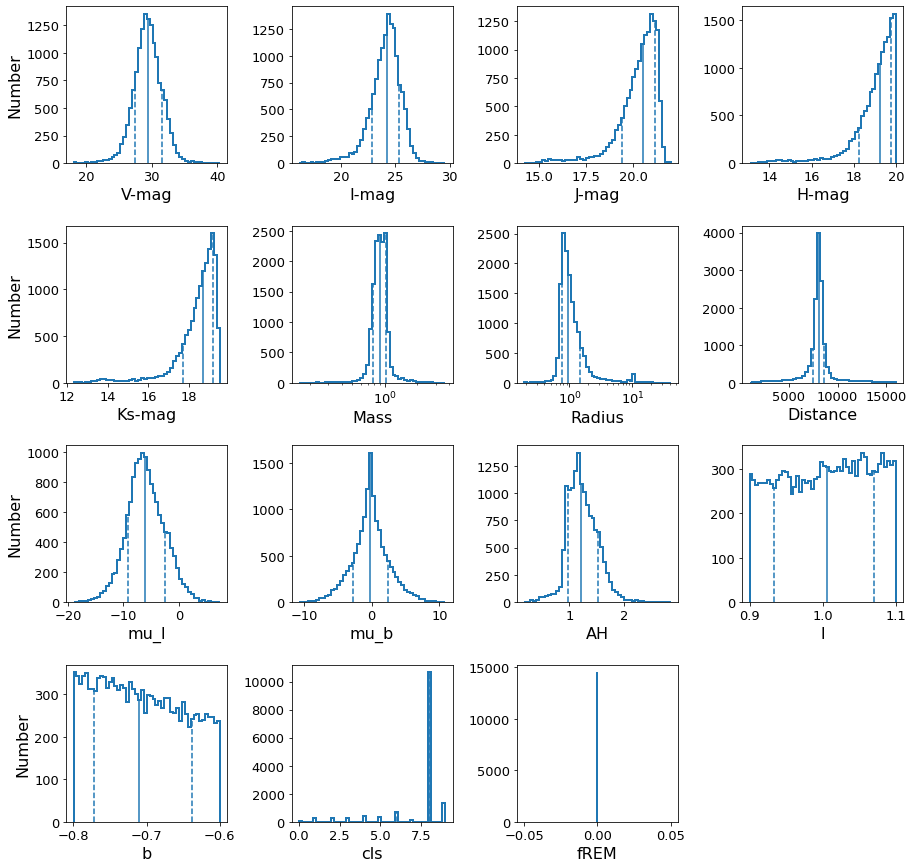

In [5]:
print_and_hist(file, header, logparams = ['Mass', 'Radius']) # logparams: header name you want to plot in logscale

You can see that the simulated range is within $0.9 < l < 1.1$, $-0.8 < b < -0.6$, and $13 < H < 20$, which are specified by the `l 0.9 1.1`, ` b -0.8 -0.6`, and `iMag 3 Magrange 13 20` options, respectively.  

In the calculation, the input sky area is further divided into 0.025 deg. x 0.025 deg. grids defined in input_files/EJK_G12_S20_LR.dat, which is originally from the [Gonzalez et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012A%26A...543A..13G/abstract) and [Surot et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...644A.140S/abstract) E(J-Ks) maps.  
Then, from the E(J-K) values of the grids, A_lambda is calculated using the [Nishiyama et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...696.1407N/abstract)'s extinction law.  
In each grid, stars with brightness within 13 < H < 20 were generated using the A_H value.  
The total number of stars 14494 with `fSIMU 0.01` indicates that there are ~1449400 stars exist within 13 < H < 20 in $0.9 < l < 1.1$, $-0.8 < b < -0.6$ in the Galactic model.


The second last parameter 'cls' indicates the flag to indicate which component the star belongs to. The components are:  
- cls   (should take 0 - 9, although for some reason the following says 1-10 when viewed on github)  
    0. Thin disk (0.1 Gyr, [Fe/H]= 0.01)
    1. Thin disk (0.6 Gyr, [Fe/H] = 0.00)
    2. Thin disk (1.5 Gyr, [Fe/H]= -0.02)
    3. Thin disk (2.5 Gyr, [Fe/H]= -0.03)
    4. Thin disk (4.0 Gyr, [Fe/H]= -0.05)
    5. Thin disk (6.0 Gyr, [Fe/H]= -0.09)
    6. Thin disk (8.7 Gyr, [Fe/H]= -0.12)
    7. Thick disk (12 Gyr, [Fe/H]= -0.78)
    8. Bulge (9.0 Gyr, [Fe/H]= 0.00)
    9. Nuclear Stellar Disk (7.0 Gyr, [Fe/H]= 0.10)

So, currently genstars uses the mono-age mono-metallicity isochrone for each component.

The last parameter 'fREM' is the flag to indicate evolutional stage of the lens. This is  
- fREM (should take 0 - 3, although for some reason the following says 1-4 when viewed on github)  
    0. Star (incl. brown dwarf, main sequence star, red giant)
    1. White dwarf
    2. Neutron star
    3. Black hole

Currently, the remnants (white dwarf, neutron star, and black hole) are assumed to be 0 brightness.  
So, now that we specified `Magrange`, the fREM takes only 0, i.e., only the stars are generated.  
Let's see the results when `Magrange` is not specified.

## A catalog generation including dark objects without `Magrange`
When you want a whole "star" catalog including remnants (white dwarf, neutron star, and black hole), the following command generates such a catalog within 0.9 < l < 1.1, -0.8 < b < -0.6.

In [6]:
%%time
# Conduct genstars and output all "star" (incl. remnants) catalog to tmp.dat
file = 'tmp.dat'
header = run_genstars("./genstars l 0.9 1.1 b -0.8 -0.6 ROMAN 0 fSIMU 0.01 iMag 3 VERBOSITY 1 seed 3 > {}".format(file))

# Conducted command (you can do this directly in your command line too): 
./genstars l 0.9 1.1 b -0.8 -0.6 ROMAN 0 fSIMU 0.01 iMag 3 VERBOSITY 1 seed 3 > tmp.dat
CPU times: user 3.62 ms, sys: 11.9 ms, total: 15.5 ms
Wall time: 2.27 s


The difference from the previous command is just the `Magrange` part; `Magrange` is not specified this time.

,V-mag,I-mag,J-mag,H-mag,Ks-mag,Mass,Radius,Distance,mu_l,mu_b,AH,l,b,cls,fREM
0,81.9420,67.5124,51.6001,48.6231,66.3146,0.003897,0.104000,6873.9,-7.0442,-0.2317,1.181,0.921628,-0.785260,8.0,0.0
1,34.6832,27.9769,23.2822,21.6095,20.8790,0.629750,0.613015,10861.0,-8.1767,0.8444,1.418,0.916206,-0.794788,4.0,0.0
2,31.5805,25.8463,21.7367,20.2705,19.6619,0.722512,0.700210,8279.3,-7.7606,0.0563,1.267,0.902381,-0.792277,8.0,0.0
3,28.7701,24.0773,20.8872,19.6410,19.1288,0.602917,0.601530,5486.7,-1.5335,-0.2255,0.834,0.913222,-0.798425,0.0,0.0
4,40.5032,31.8607,25.9787,24.1009,23.1305,0.415726,0.407011,15138.8,-5.4755,-0.3172,1.755,0.902468,-0.783315,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260715,38.8172,30.5814,25.0600,23.3179,22.3858,0.301214,0.310052,8207.1,-9.0475,3.0696,1.568,1.091509,-0.615714,8.0,0.0
260716,51.8813,39.8874,32.3447,31.5306,31.2351,0.062729,0.076546,7941.5,0.4569,2.7980,1.331,1.090697,-0.609992,8.0,0.0
260717,42.1205,32.9826,27.0828,25.2292,24.2768,0.127705,0.161448,8541.7,-10.2028,-2.9272,1.573,1.090409,-0.614978,8.0,0.0
260718,99.0000,99.0000,99.0000,99.0000,99.0000,0.531282,0.009174,7499.1,-0.1900,-0.3944,1.408,1.081676,-0.615640,5.0,1.0


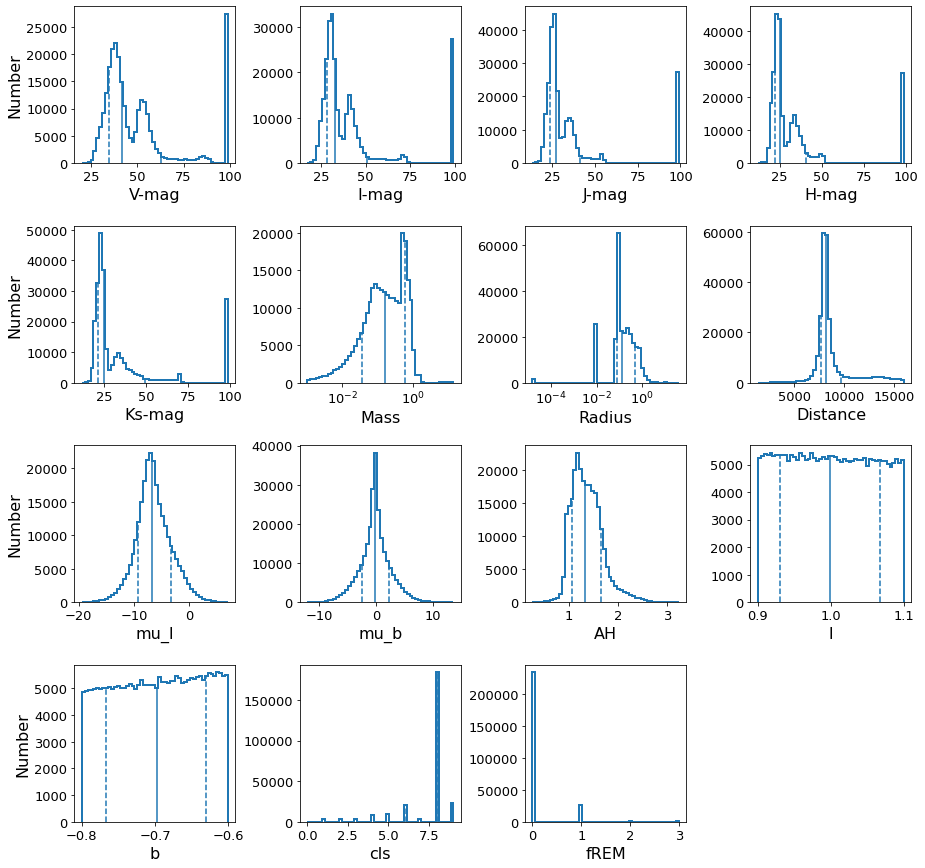

In [7]:
print_and_hist(file, header, logparams = ['Mass', 'Radius']) # logparams: header name you want to plot in logscale

This time you can see some population of fREM > 0. The remnants are assigned mag = 99, which makes the far right bins in the magnitudes panels. Some white dwarfs can be detectable with very deep observations, so this treatment is problematic in such cases, but not in many cases.  
Even with the same fSIMU value of 0.01, the number of generated stars is ~18 times larger than the previous example with `Magrange`.
This is because there are more fainter stars in our Galaxy.  
The number of generated stars is $2.6 \times 10^5$, so it would be $2.6 \times 10^7$ if you used fSIMU = 1 for this.  
So it could quite easily overwhelm your storage, and I strongly recommend testing with the `VERBOSITY 0` option before running `genstars`, especially if `Magrange` is wide (or not set) and/or the simulated sky area is large.  
### Example of test run with `VERBOSITY 0`
With the `VERBOSITY 0` option, no parameters are outputted for each star, but a brief summary of the simulated stars is outputted at the footer part;

In [8]:
%%time
# Test run with a large sky area and VERBOSITY 0. DO NOT DO THIS with VERBOSITY > 0
# takes ~40 secs.
from subprocess import PIPE
file = 'tmp.dat'
header = run_genstars("./genstars l -1.5 1.5 b -1.5 1.5 ROMAN 0 fSIMU 0.001 iMag 3 VERBOSITY 0 seed 3 > {}".format(file))
# Print the footer part showing the brief summary
command = 'tail -n 2 {}'.format(file)
proc = subprocess.run(command, shell=True, stdout=PIPE, stderr=PIPE, text=True)
print(command)
print('{}'.format(proc.stdout))

# Conducted command (you can do this directly in your command line too): 
./genstars l -1.5 1.5 b -1.5 1.5 ROMAN 0 fSIMU 0.001 iMag 3 VERBOSITY 0 seed 3 > tmp.dat
tail -n 2 tmp.dat
# (n_thin1-7 n_thick n_bar n_nsd)/n_all= (  18673  71666  83762  85570 181016 214033 456582  90993 4334623 2722765 ) / 8259683 = ( 0.002261 0.008677 0.010141 0.010360 0.021916 0.025913 0.055278 0.011017 0.524793 0.329645 )
# (n_BD n_MS n_WD n_NS n_BH)/n_all= ( 2591938 4816776 798480  35560  16929 ) / 8259683 = ( 0.313806 0.583167 0.096672 0.004305 0.002050 )

CPU times: user 5.98 ms, sys: 18.6 ms, total: 24.6 ms
Wall time: 37 s


This test run tells you that the `genstars` run will outputs ~8259683000 (= n_all / fSIMU) lines if you use `VERBOSITY` > 0 and `fSIMU 1`.  
So, you might want to keep `fSIMU 0.001` or smaller if you want to output the parameters of each star. This depends on how much resolution data you want and how eager you are to save storage, though.